In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import matplotlib.dates as mdates
from bs4 import BeautifulSoup
import requests
import glob
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import os
import re
from scipy.stats import pearsonr

### 데이터 전처리

In [2]:
# 파일 불러오고, 결합
file_list = glob.glob('../data/raw/forecast_1525/forecast_*.csv')
df_list = [pd.read_csv(file, encoding='euc-kr') for file in file_list]
forecast_df = pd.concat(df_list, ignore_index=True)

In [3]:
forecast_df['일시'] = pd.to_datetime(forecast_df['일시'])
forecast_df.head()

# '일시'에서 날짜만 추출 / '지점'과 "날짜"별로 그룹화 / 각 그룹별 평균 계산
forecast_df['날짜'] = forecast_df['일시'].dt.date  # 날짜만 추출
grouped = forecast_df.groupby(['지점', '날짜'])
daily_avg = grouped.mean().reset_index()
# daily_avg
#----------------이하 위치별 dataframe---------------
#부안
df_buan = daily_avg[daily_avg['지점'] ==22186]
# df_buan

#가거도
df_gageodo = daily_avg[daily_avg['지점'].isin([22297, 22193])]
# df_gageodo

#마라도
df_marado = daily_avg[daily_avg['지점'] ==22107]
# df_marado

#통영
df_tongyoung = daily_avg[daily_avg['지점'] ==22188]
# df_tongyoung

#동해
df_donghae = daily_avg[daily_avg['지점'].isin([22105, 22305, 22302])]
df_donghae_combined = df_donghae.groupby('날짜').mean(numeric_only=True).reset_index()
df_donghae_combined['지점'] = 22105

# df_donghae_combined

In [4]:
df_buan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3145 entries, 7165 to 10309
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   지점           3145 non-null   int64         
 1   날짜           3145 non-null   object        
 2   일시           3145 non-null   datetime64[ns]
 3   풍속(m/s)      3138 non-null   float64       
 4   풍향(deg)      3138 non-null   float64       
 5   GUST풍속(m/s)  3055 non-null   float64       
 6   현지기압(hPa)    3134 non-null   float64       
 7   습도(%)        3089 non-null   float64       
 8   기온(°C)       3113 non-null   float64       
 9   수온(°C)       3139 non-null   float64       
 10  최대파고(m)      3144 non-null   float64       
 11  유의파고(m)      3144 non-null   float64       
 12  평균파고(m)      3140 non-null   float64       
 13  파주기(sec)     3144 non-null   float64       
 14  파향(deg)      3144 non-null   float64       
dtypes: datetime64[ns](1), float64(12), int64(1), object(1)
m

### 이하 위 데이터프레임 시각화

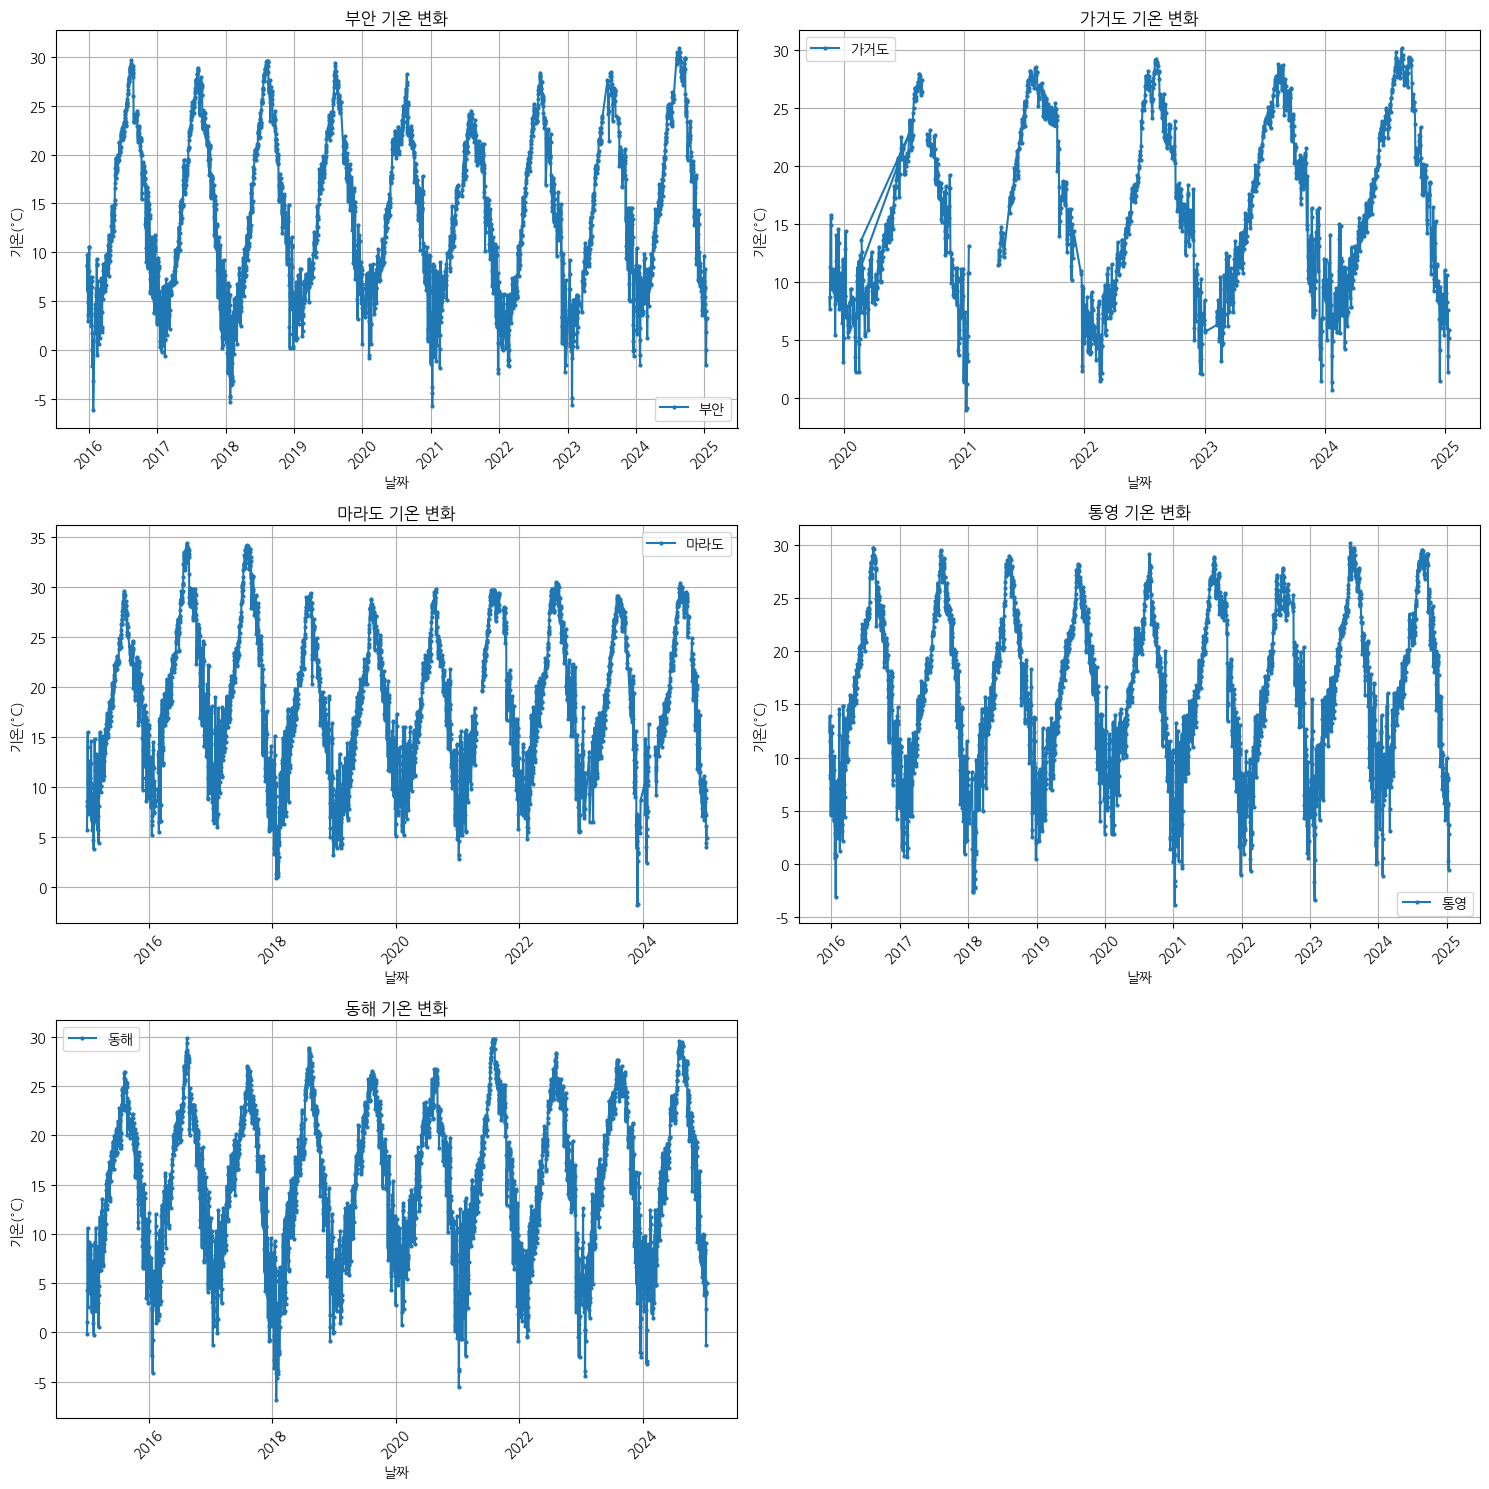

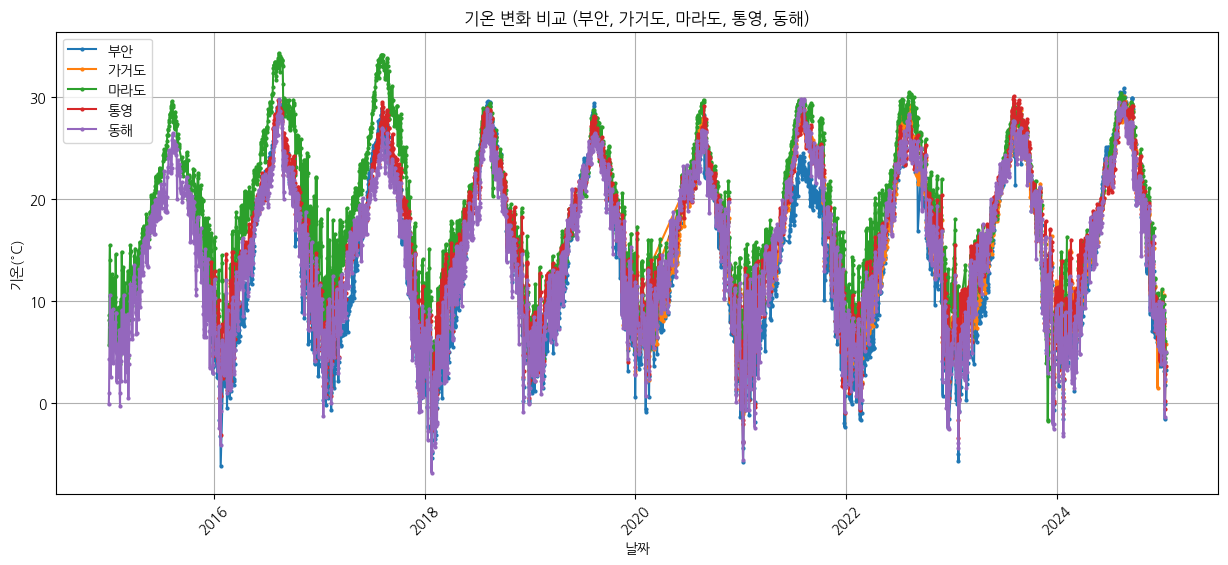

In [5]:
dfs = [df_buan, df_gageodo, df_marado, df_tongyoung, df_donghae_combined]
labels = ['부안', '가거도', '마라도', '통영', '동해']

# 1. 서브플롯: 각각 별도의 차트에 시각화
plt.figure(figsize=(15, 15))  # 서브플롯 크기 설정
for i, (df, label) in enumerate(zip(dfs, labels), start=1):
    plt.subplot(3, 2, i)  # 3행 2열 형태의 서브플롯
    plt.plot(df['날짜'], df['기온(°C)'], label=label, marker='o', markersize=2)
    plt.title(f'{label} 기온 변화')
    plt.xlabel('날짜')
    plt.ylabel('기온(°C)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
for df, label in zip(dfs, labels):
    plt.plot(df['날짜'], df['기온(°C)'], label=label, marker='o', markersize=2)

plt.title('기온 변화 비교 (부안, 가거도, 마라도, 통영, 동해)')
plt.xlabel('날짜')
plt.ylabel('기온(°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

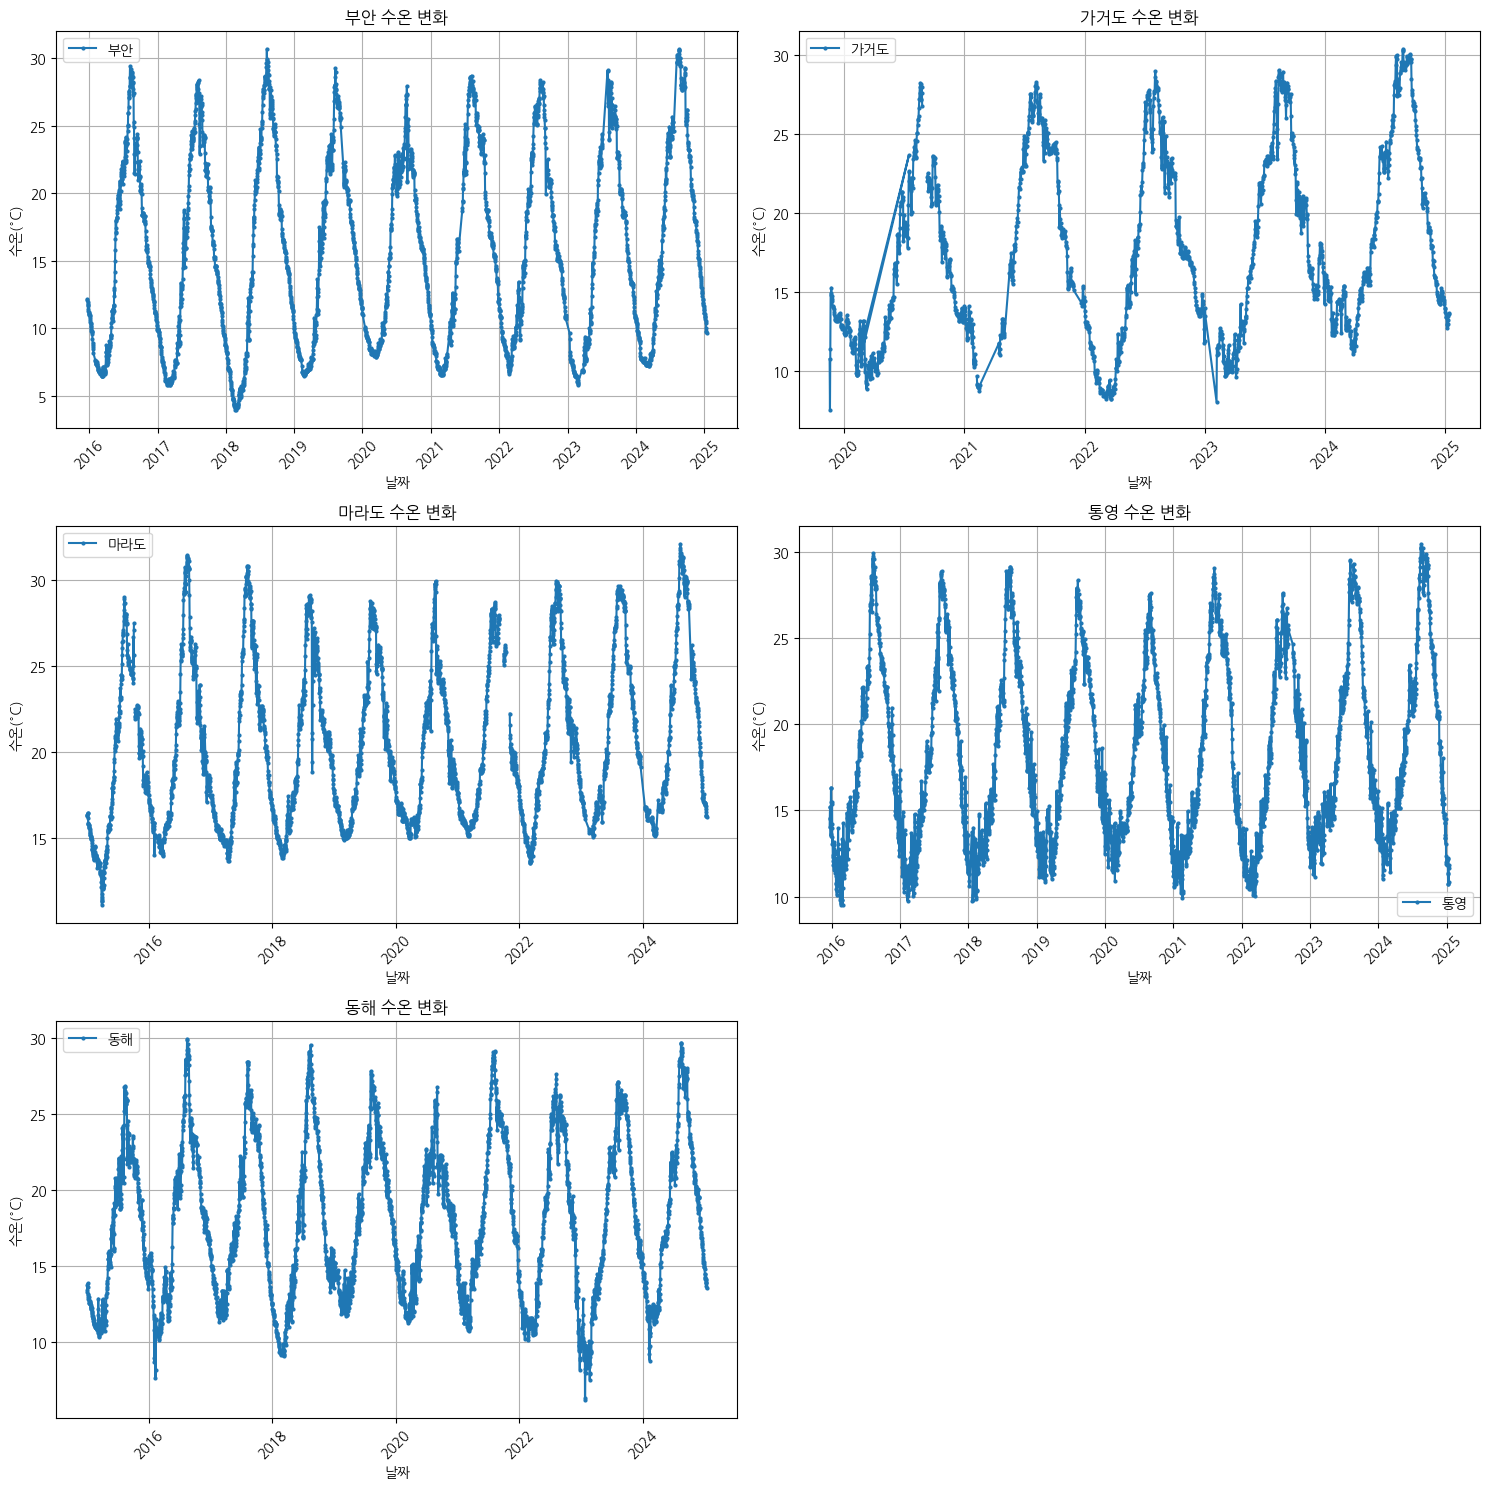

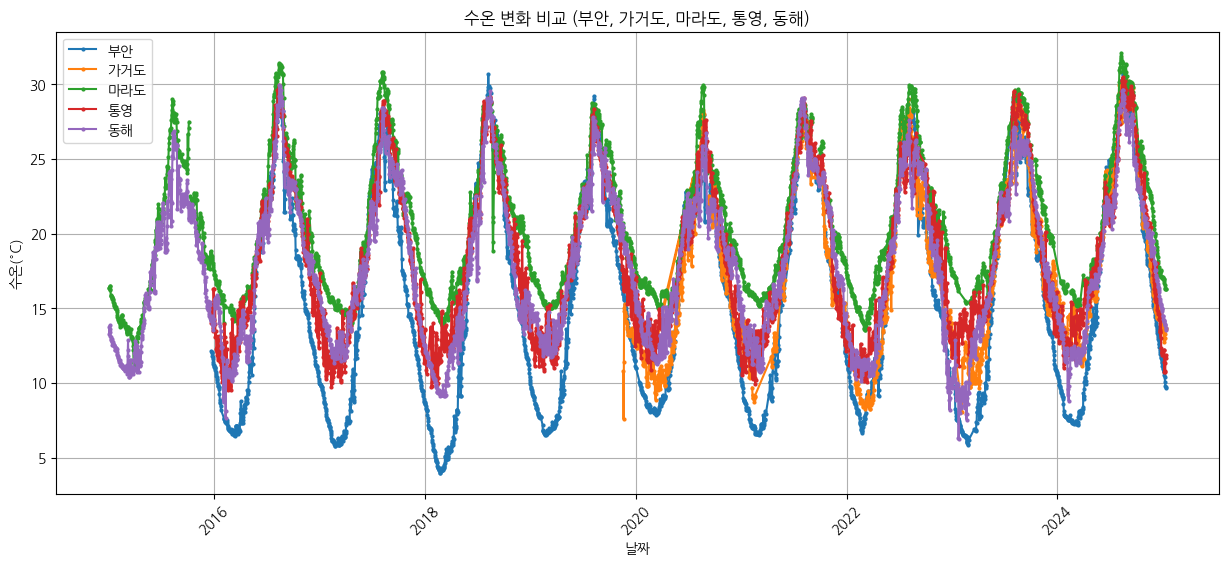

In [6]:
dfs = [df_buan, df_gageodo, df_marado, df_tongyoung, df_donghae_combined]
labels = ['부안', '가거도', '마라도', '통영', '동해']

# 1. 서브플롯: 각각 별도의 차트에 시각화
plt.figure(figsize=(15, 15))  # 서브플롯 크기 설정
for i, (df, label) in enumerate(zip(dfs, labels), start=1):
    plt.subplot(3, 2, i)  # 3행 2열 형태의 서브플롯
    plt.plot(df['날짜'], df['수온(°C)'], label=label, marker='o', markersize=2)
    plt.title(f'{label} 수온 변화')
    plt.xlabel('날짜')
    plt.ylabel('수온(°C)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
for df, label in zip(dfs, labels):
    plt.plot(df['날짜'], df['수온(°C)'], label=label, marker='o', markersize=2)

plt.title('수온 변화 비교 (부안, 가거도, 마라도, 통영, 동해)')
plt.xlabel('날짜')
plt.ylabel('수온(°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

### 이하 적조 데이터

In [7]:
redtide= "../data/raw/적조데이터.csv"
df = pd.read_csv(redtide, encoding='utf-8-sig')
df = df.drop(columns=['좌표'])  

# 수온과 염분의 중간값을 계산하는 함수
def calculate_mid_value(range_str):
    try:
        # 값이 float으로 저장된 경우 문자열로 변환
        range_str = str(range_str)

        # '~' 구분자로 값 나누기
        if '~' in range_str:
            lower, upper = map(float, range_str.split('~'))
            return (lower + upper) / 2
        else:
            return float(range_str)  # 범위가 아니라 단일 값이 있을 경우 처리
    except ValueError:
        return None  # 데이터가 비정상적일 경우 None 반환

# 컬럼을 문자열로 변환 (오류 방지)
df['수온'] = df['수온'].astype(str)
df['염분'] = df['염분'].astype(str)

# '수온(C)'과 '염분' 컬럼에 중간값 적용
df['수온'] = df['수온'].apply(calculate_mid_value)
df['염분'] = df['염분'].apply(calculate_mid_value)

df.head()

,예찰일자,발생해역,적조생물,밀도(개체수/mL),수온,염분
0,2024-09-10,-,없음,0~0,28.1,31.90
1,2024-09-09,-,없음,0~0,27.9,31.70
2,2024-09-08,-,없음,0~0,27.4,31.70
3,2024-09-07,-,없음,0~0,27.1,31.35
4,2024-09-06,-,없음,0~0,27.3,31.80


# 이하 가격 지연 최적치

In [6]:
# 가격 지연 최적치 함수
def lags(Market, Item):
    # 데이터 로드 및 전처리
    price_data = pd.read_csv('../data/prep/item_price_filled_pivot.csv', encoding='utf-8-sig')
    price_data['날짜'] = pd.to_datetime(price_data['priceDate']).dt.date

    # 특정 시장과 품목의 가격 필터링
    data_noryang = price_data[price_data['market'] == Market]
    data_noryang = data_noryang.filter(items=['날짜', f'{Item}_avgPrice'])

    daily_avg_price = data_noryang.groupby('날짜').mean().reset_index()
    daily_avg_price.rename(columns={f'{Item}_avgPrice': 'avgPrice'}, inplace=True)

    # 기상 데이터 불러오기 및 전처리
    forecast_df = pd.read_csv('../data/prep/forecast_agg.csv', encoding='utf-8-sig')
    forecast_df['날짜'] = pd.to_datetime(forecast_df['일시']).dt.date
    forecast_df = forecast_df.drop(columns=['지점', '일시'])
    daily_avg_weather = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

    # 최적 지연 기간 찾기 함수
    def find_optimal_lags_with_confidence(fish_prices, weather_data, feature_list, max_lag=600, bootstrap_samples=50):
        results = {}

        for feature in feature_list:
            best_corr = -1
            best_lag = 0
            bootstrap_lags = []

            for lag in range(1, max_lag + 1):
                shifted_prices = fish_prices.copy()
                shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag)
                shifted_prices.dropna(inplace=True)
                merged_df = pd.merge(shifted_prices, weather_data[['날짜', feature]], on='날짜', how='inner')
                if merged_df.empty:
                    continue

                # 상관관계 분석
                scaler = StandardScaler()
                weather_scaled = scaler.fit_transform(merged_df[[feature]])
                price_scaled = scaler.fit_transform(merged_df[['avgPrice']])

                corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
                if corr > best_corr:
                    best_corr = corr
                    best_lag = lag

            # 부트스트래핑을 통한 신뢰 구간 계산
            for _ in range(bootstrap_samples):
                sampled_indices = np.random.choice(len(merged_df), len(merged_df), replace=True)
                # sampled_prices = fish_prices.iloc[sampled_indices]
                # shifted_sample = sampled_prices.copy()
                # shifted_sample['날짜'] = shifted_sample['날짜'] - pd.Timedelta(days=best_lag)
                # shifted_sample.dropna(inplace=True)
                sampled_merged = merged_df.iloc[sampled_indices]

                if not sampled_merged.empty:
                    weather_scaled = scaler.fit_transform(sampled_merged[[feature]])
                    price_scaled = scaler.fit_transform(sampled_merged[['avgPrice']])
                    boot_corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
                    bootstrap_lags.append(boot_corr)

            conf_low, conf_high = np.percentile(bootstrap_lags, [2.5, 97.5])

            results[feature] = {
                '최적 지연 기간': best_lag,
                '상관계수': best_corr,
                '신뢰구간': (conf_low, conf_high)
            }

        return results

    # 분석 수행
    feature_columns = daily_avg_weather.columns.drop('날짜')
    optimal_lags_with_confidence = find_optimal_lags_with_confidence(daily_avg_price, daily_avg_weather, feature_columns)

    # 결과 출력
    print(f"\n가격 기준 기상 요인의 최적 지연 기간 및 신뢰구간(품목={Item}/ 시장={Market}/ 부이=평균):")
    for feature, result in optimal_lags_with_confidence.items():
        print(f"{feature}: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}, 신뢰구간: {result['신뢰구간'][0]:.4f} ~ {result['신뢰구간'][1]:.4f}, 범위: {result['신뢰구간'][1] - result['신뢰구간'][0]:.4f}")

    # 시각화
    plt.figure(figsize=(12, 8))
    sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],
                y=list(optimal_lags_with_confidence.keys()),
                palette='viridis')
    plt.title(f'{Market} {Item} 가격에 대한 기상 요인의 최적 지연 기간')
    plt.xlabel('최적 지연 기간 (일)')
    plt.ylabel('기상 요인')
    plt.grid()
    plt.show()

              풍속     GUST풍속         현지기압         습도         기온         수온  \
0      10.808696  15.126087  1016.200000  65.130435  -0.121739  13.752174   
1       9.725000  13.791667  1018.875000  60.083333   1.029167  13.262500   
2       3.520833   6.083333  1019.725000  39.750000   4.337500  13.391667   
3       4.558333   6.695833  1015.858333  54.000000   8.091667  13.862500   
4       6.708696   8.939130  1016.352174  57.086957  10.613043  13.608696   
...          ...        ...          ...        ...        ...        ...   
23736   3.641667   5.437500  1030.700000  51.625000   9.258333  17.062500   
23737   7.466667   9.854167  1021.891667  51.583333  11.937500  16.850000   
23738   8.333333  10.666667  1017.745833  51.750000  12.854167  17.212500   
23739  10.116667  13.275000  1020.795833  49.666667  10.362500  16.141667   
23740   7.300000  10.200000  1026.300000  43.000000   9.500000  15.600000   

       최대파고      유의파고      평균파고       파주기          날짜  
0       6.7  3.0956

C:\Users\user\AppData\Local\Temp\ipykernel_3572\2376718171.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],


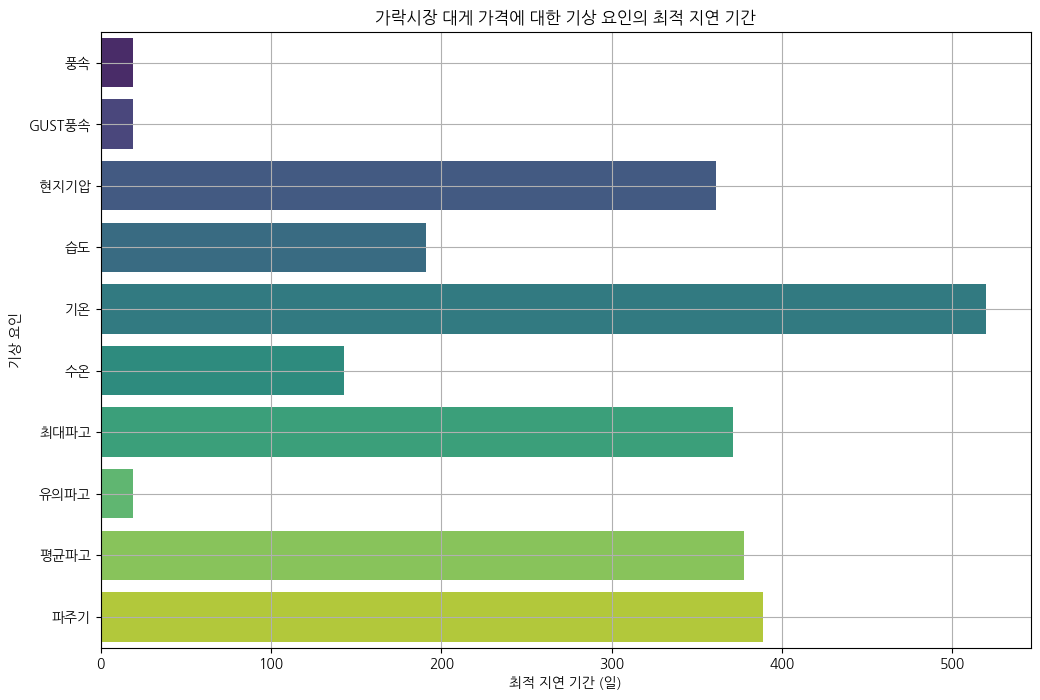

              풍속     GUST풍속         현지기압         습도         기온         수온  \
0      10.808696  15.126087  1016.200000  65.130435  -0.121739  13.752174   
1       9.725000  13.791667  1018.875000  60.083333   1.029167  13.262500   
2       3.520833   6.083333  1019.725000  39.750000   4.337500  13.391667   
3       4.558333   6.695833  1015.858333  54.000000   8.091667  13.862500   
4       6.708696   8.939130  1016.352174  57.086957  10.613043  13.608696   
...          ...        ...          ...        ...        ...        ...   
23736   3.641667   5.437500  1030.700000  51.625000   9.258333  17.062500   
23737   7.466667   9.854167  1021.891667  51.583333  11.937500  16.850000   
23738   8.333333  10.666667  1017.745833  51.750000  12.854167  17.212500   
23739  10.116667  13.275000  1020.795833  49.666667  10.362500  16.141667   
23740   7.300000  10.200000  1026.300000  43.000000   9.500000  15.600000   

       최대파고      유의파고      평균파고       파주기          날짜  
0       6.7  3.0956

C:\Users\user\AppData\Local\Temp\ipykernel_3572\2376718171.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],


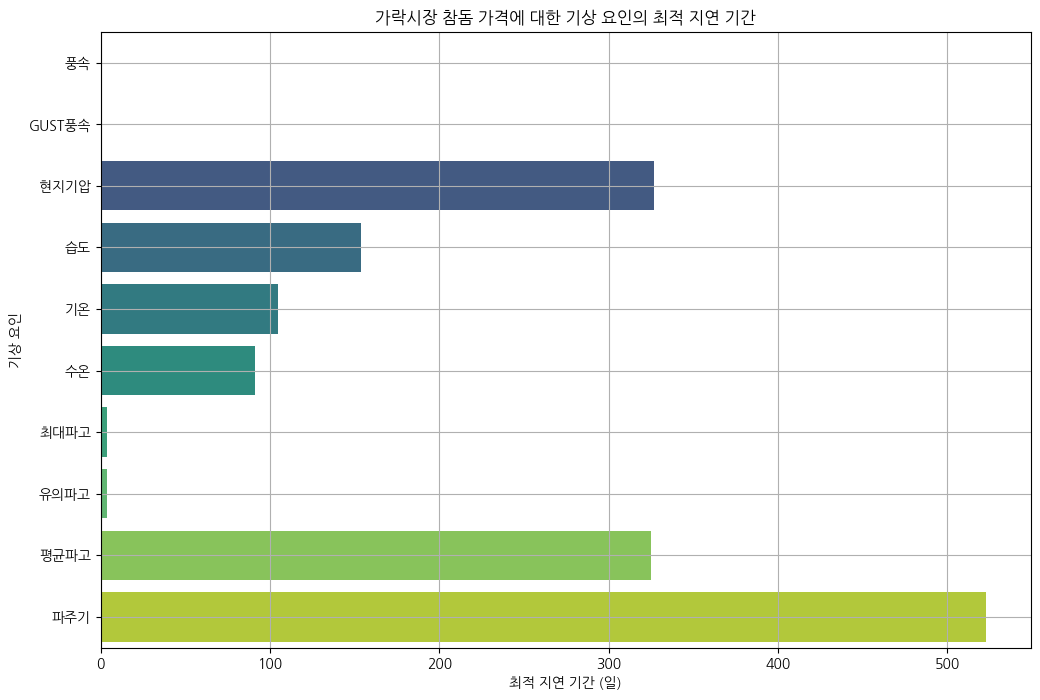

              풍속     GUST풍속         현지기압         습도         기온         수온  \
0      10.808696  15.126087  1016.200000  65.130435  -0.121739  13.752174   
1       9.725000  13.791667  1018.875000  60.083333   1.029167  13.262500   
2       3.520833   6.083333  1019.725000  39.750000   4.337500  13.391667   
3       4.558333   6.695833  1015.858333  54.000000   8.091667  13.862500   
4       6.708696   8.939130  1016.352174  57.086957  10.613043  13.608696   
...          ...        ...          ...        ...        ...        ...   
23736   3.641667   5.437500  1030.700000  51.625000   9.258333  17.062500   
23737   7.466667   9.854167  1021.891667  51.583333  11.937500  16.850000   
23738   8.333333  10.666667  1017.745833  51.750000  12.854167  17.212500   
23739  10.116667  13.275000  1020.795833  49.666667  10.362500  16.141667   
23740   7.300000  10.200000  1026.300000  43.000000   9.500000  15.600000   

       최대파고      유의파고      평균파고       파주기          날짜  
0       6.7  3.0956

KeyboardInterrupt: 

In [7]:
# 함수 호출
markets = ['가락시장','노량진 1층']
items = ['대게','참돔']
for market in markets:
    for item in items:
        lags(market, item)

#List : 
# markets
#'가락시장', '노량진 1층', '노량진 2층', '구리농수산물시장', '수원농수산물시장', '강서농수산물시장', 
#'마포농수산물시장', '안양평촌농수산물시장', '부산민락어민활어직판장', '소래포구종합어시장', '인천종합연안부두어시장'

#items:
#'광어', '농어', '대게', '방어', '연어', '우럭', '참돔'

### 이하 최적치 원코드

C:\Users\user\AppData\Local\Temp\ipykernel_7712\597248972.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_avg_price.rename(columns={'대게_avgPrice': 'avgPrice'}, inplace=True)



기상 요인의 최적 지연 기간 및 신뢰구간(시장/부이=평균):
풍속: 360일, 상관계수: 0.2653, 신뢰구간: 0.2341 ~ 0.2951, 범위: 0.0610
GUST풍속: 360일, 상관계수: 0.2912, 신뢰구간: 0.2647 ~ 0.3127, 범위: 0.0480
현지기압: 347일, 상관계수: 0.4681, 신뢰구간: 0.4487 ~ 0.4906, 범위: 0.0419
습도: 545일, 상관계수: 0.4410, 신뢰구간: 0.4091 ~ 0.4615, 범위: 0.0524
기온: 518일, 상관계수: 0.5867, 신뢰구간: 0.5633 ~ 0.6045, 범위: 0.0412
수온: 508일, 상관계수: 0.5844, 신뢰구간: 0.5622 ~ 0.5983, 범위: 0.0361
최대파고: 373일, 상관계수: 0.2268, 신뢰구간: 0.2024 ~ 0.2535, 범위: 0.0511
유의파고: 373일, 상관계수: 0.2314, 신뢰구간: 0.2023 ~ 0.2598, 범위: 0.0575
평균파고: 373일, 상관계수: 0.2763, 신뢰구간: 0.2473 ~ 0.3000, 범위: 0.0527
파주기: 383일, 상관계수: 0.1635, 신뢰구간: 0.1354 ~ 0.1903, 범위: 0.0548


C:\Users\user\AppData\Local\Temp\ipykernel_7712\597248972.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],


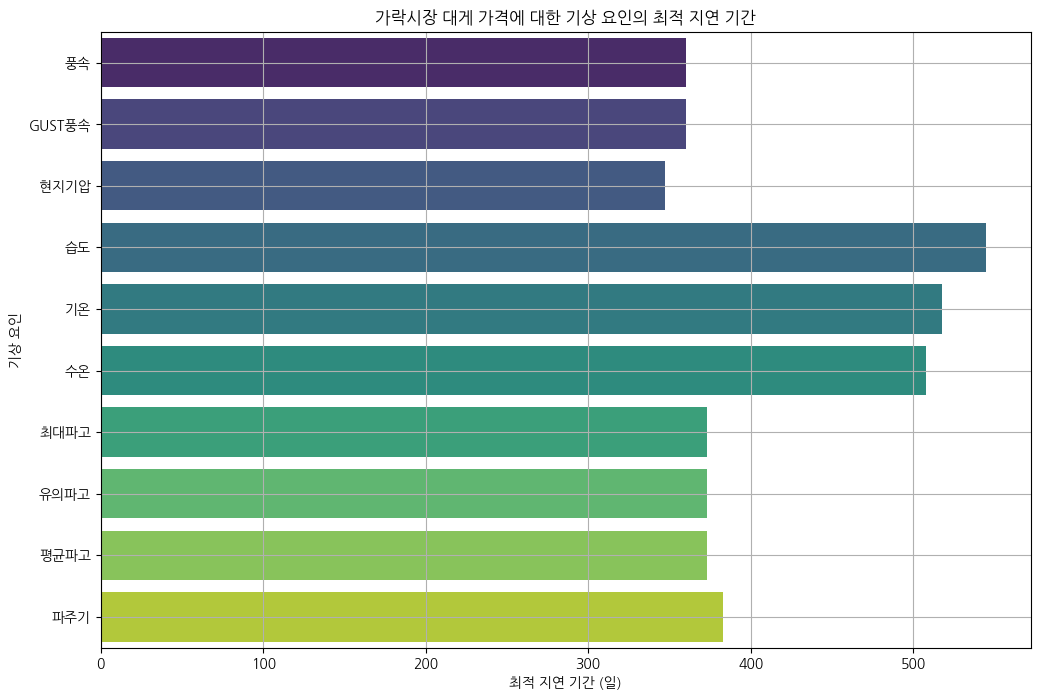

In [11]:
# 데이터 로드 및 전처리
price_data = pd.read_csv('../data/prep/item_price_filled_pivot.csv', encoding='utf-8-sig')
price_data['날짜'] = pd.to_datetime(price_data['priceDate']).dt.date

# 모든 시장 데이터에 대해 평균 계산
data_all_markets = price_data.groupby('날짜').mean(numeric_only=True).reset_index()

# 대게 가격 데이터 선택 및 컬럼명 변경
daily_avg_price = data_all_markets[['날짜', '대게_avgPrice']]
daily_avg_price.rename(columns={'대게_avgPrice': 'avgPrice'}, inplace=True)

# 기상 데이터 불러오기 및 전처리
forecast_df = pd.read_csv('../data/prep/forecast_agg.csv', encoding='utf-8-sig')
forecast_df['날짜'] = pd.to_datetime(forecast_df['일시']).dt.date
forecast_df = forecast_df.drop(columns=['지점', '일시'])
daily_avg_weather = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

# 최적 지연 기간 찾기 함수
def find_optimal_lags_with_confidence(fish_prices, weather_data, feature_list, max_lag=600, bootstrap_samples=50):
    results = {}

    for feature in feature_list:
        best_corr = -1
        best_lag = 0
        bootstrap_lags = []

        for lag in range(1, max_lag + 1):
            shifted_prices = fish_prices.copy()
            shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag)

            merged_df = pd.merge(shifted_prices, weather_data[['날짜', feature]], on='날짜', how='inner')
            if merged_df.empty:
                continue

            # 상관관계 분석
            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(merged_df[[feature]])
            price_scaled = scaler.fit_transform(merged_df[['avgPrice']])

            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())

            if corr > best_corr:
                best_corr = corr
                best_lag = lag

        # 부트스트래핑을 통한 신뢰 구간 계산
        for _ in range(bootstrap_samples):
            sampled_indices = np.random.choice(len(fish_prices), len(fish_prices), replace=True)
            sampled_prices = fish_prices.iloc[sampled_indices]
            shifted_sample = sampled_prices.copy()
            shifted_sample['날짜'] = shifted_sample['날짜'] - pd.Timedelta(days=best_lag)
            sampled_merged = pd.merge(shifted_sample, weather_data[['날짜', feature]], on='날짜', how='inner')

            if not sampled_merged.empty:
                weather_scaled = scaler.fit_transform(sampled_merged[[feature]])
                price_scaled = scaler.fit_transform(sampled_merged[['avgPrice']])
                boot_corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
                bootstrap_lags.append(boot_corr)

        conf_low, conf_high = np.percentile(bootstrap_lags, [2.5, 97.5])

        results[feature] = {
            '최적 지연 기간': best_lag,
            '상관계수': best_corr,
            '신뢰구간': (conf_low, conf_high)
        }

    return results

# 분석 수행
feature_columns = daily_avg_weather.columns.drop('날짜')
optimal_lags_with_confidence = find_optimal_lags_with_confidence(daily_avg_price, daily_avg_weather, feature_columns)

# 결과 출력
print("\n기상 요인의 최적 지연 기간 및 신뢰구간(시장/부이=평균):")
for feature, result in optimal_lags_with_confidence.items():
    print(f"{feature}: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}, 신뢰구간: {result['신뢰구간'][0]:.4f} ~ {result['신뢰구간'][1]:.4f}, 범위: {result['신뢰구간'][1] - result['신뢰구간'][0]:.4f}")

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],
            y=list(optimal_lags_with_confidence.keys()),
            palette='viridis')
plt.title('가락시장 대게 가격에 대한 기상 요인의 최적 지연 기간')
plt.xlabel('최적 지연 기간 (일)')
plt.ylabel('기상 요인')
plt.grid()
plt.show()


### 이하 시장 전체 평균(미완)

C:\Users\user\AppData\Local\Temp\ipykernel_23148\1263200121.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_avg_price.rename(columns={f'{item_name}_avgPrice': 'avgPrice'}, inplace=True)



기상 요인의 최적 지연 기간 및 신뢰구간(품목=대게):
풍속: 360일, 상관계수: 0.2653, 신뢰구간: 0.2430 ~ 0.2955, 범위: 0.0525
GUST풍속: 360일, 상관계수: 0.2912, 신뢰구간: 0.2706 ~ 0.3320, 범위: 0.0615
현지기압: 347일, 상관계수: 0.4681, 신뢰구간: 0.4501 ~ 0.4849, 범위: 0.0348
습도: 545일, 상관계수: 0.4410, 신뢰구간: 0.4130 ~ 0.4691, 범위: 0.0562
기온: 518일, 상관계수: 0.5867, 신뢰구간: 0.5658 ~ 0.6011, 범위: 0.0353
수온: 508일, 상관계수: 0.5844, 신뢰구간: 0.5689 ~ 0.6037, 범위: 0.0347
최대파고: 373일, 상관계수: 0.2268, 신뢰구간: 0.1990 ~ 0.2557, 범위: 0.0567
유의파고: 373일, 상관계수: 0.2314, 신뢰구간: 0.1897 ~ 0.2684, 범위: 0.0787
평균파고: 373일, 상관계수: 0.2763, 신뢰구간: 0.2516 ~ 0.3051, 범위: 0.0535
파주기: 383일, 상관계수: 0.1635, 신뢰구간: 0.1406 ~ 0.2073, 범위: 0.0667


C:\Users\user\AppData\Local\Temp\ipykernel_23148\1263200121.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],


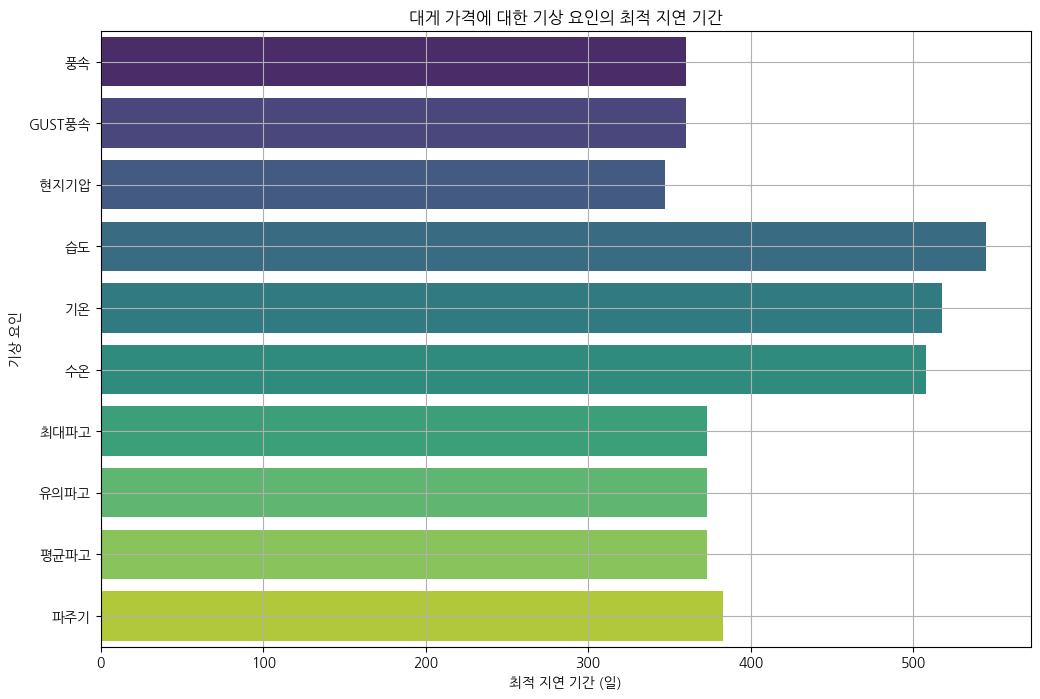

C:\Users\user\AppData\Local\Temp\ipykernel_23148\1263200121.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_avg_price.rename(columns={f'{item_name}_avgPrice': 'avgPrice'}, inplace=True)



기상 요인의 최적 지연 기간 및 신뢰구간(품목=참돔):
풍속: 326일, 상관계수: 0.0857, 신뢰구간: 0.0358 ~ 0.1157, 범위: 0.0799
GUST풍속: 304일, 상관계수: 0.0901, 신뢰구간: 0.0614 ~ 0.1264, 범위: 0.0650
현지기압: 323일, 상관계수: 0.1519, 신뢰구간: 0.1188 ~ 0.1798, 범위: 0.0609
습도: 503일, 상관계수: 0.1505, 신뢰구간: 0.1234 ~ 0.1856, 범위: 0.0621
기온: 467일, 상관계수: 0.2310, 신뢰구간: 0.1937 ~ 0.2607, 범위: 0.0671
수온: 441일, 상관계수: 0.2384, 신뢰구간: 0.2008 ~ 0.2704, 범위: 0.0696
최대파고: 303일, 상관계수: 0.0274, 신뢰구간: 0.0031 ~ 0.0587, 범위: 0.0556
유의파고: 325일, 상관계수: 0.0400, 신뢰구간: 0.0144 ~ 0.0795, 범위: 0.0651
평균파고: 317일, 상관계수: 0.1222, 신뢰구간: 0.0963 ~ 0.1448, 범위: 0.0484
파주기: 598일, 상관계수: -0.0071, 신뢰구간: -0.0367 ~ 0.0264, 범위: 0.0631


C:\Users\user\AppData\Local\Temp\ipykernel_23148\1263200121.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],


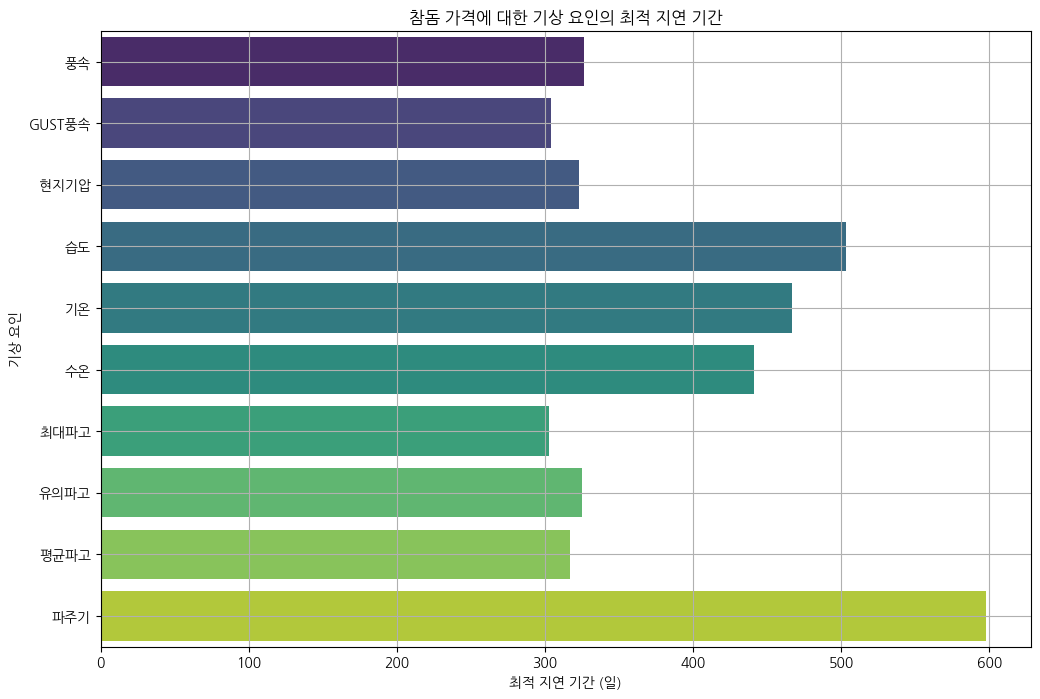

C:\Users\user\AppData\Local\Temp\ipykernel_23148\1263200121.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_avg_price.rename(columns={f'{item_name}_avgPrice': 'avgPrice'}, inplace=True)



기상 요인의 최적 지연 기간 및 신뢰구간(품목=방어):
풍속: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
GUST풍속: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
현지기압: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
습도: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
기온: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
수온: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
최대파고: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
유의파고: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
평균파고: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
파주기: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan


C:\Users\user\AppData\Local\Temp\ipykernel_23148\1263200121.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],


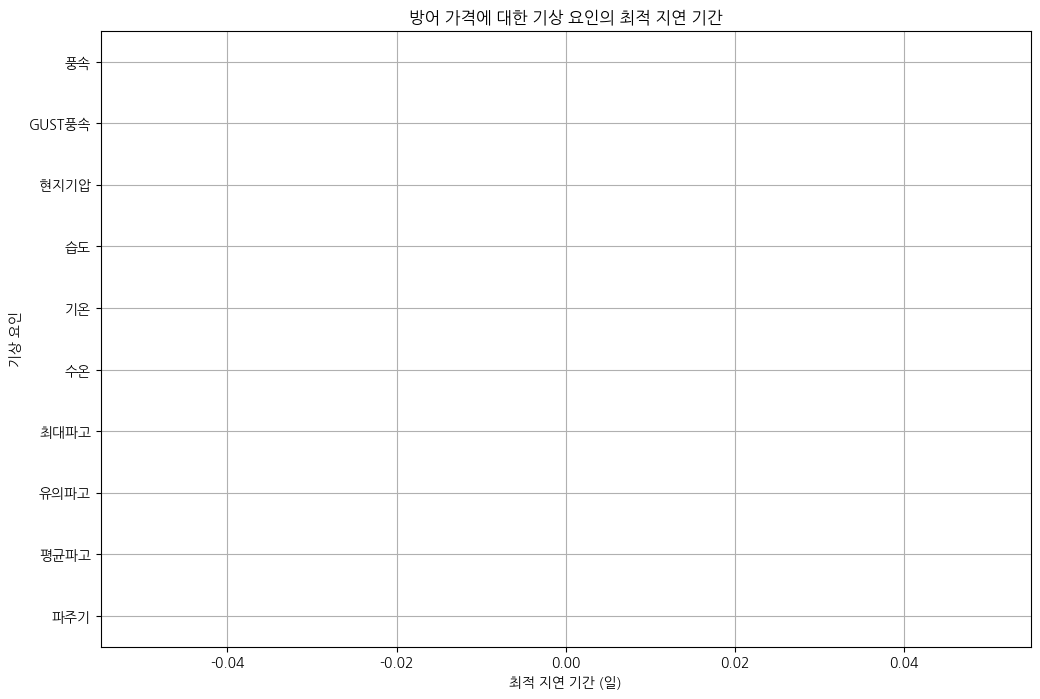

In [269]:
def process_price_data(file_path, item_name):
    price_data = pd.read_csv(file_path, encoding='utf-8-sig')
    price_data['날짜'] = pd.to_datetime(price_data['priceDate']).dt.date

    # 모든 시장 평균
    data_all_markets = price_data.groupby('날짜').mean(numeric_only=True).reset_index()
    daily_avg_price = data_all_markets[['날짜', f'{item_name}_avgPrice']]
    daily_avg_price.rename(columns={f'{item_name}_avgPrice': 'avgPrice'}, inplace=True)
    return daily_avg_price

def process_weather_data(file_path):
    forecast_df = pd.read_csv(file_path, encoding='utf-8-sig')
    forecast_df['날짜'] = pd.to_datetime(forecast_df['일시']).dt.date
    forecast_df = forecast_df.drop(columns=['지점', '일시'])
    daily_avg_weather = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()
    return daily_avg_weather

def find_optimal_lags_with_confidence(fish_prices, weather_data, feature_list, max_lag=600, bootstrap_samples=50):
    results = {}

    for feature in feature_list:
        best_corr = -1
        best_lag = 0
        bootstrap_lags = []

        for lag in range(1, max_lag + 1):
            shifted_prices = fish_prices.copy()
            shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag)

            merged_df = pd.merge(shifted_prices, weather_data[['날짜', feature]], on='날짜', how='inner')
            if merged_df.empty:
                continue

            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(merged_df[[feature]])
            price_scaled = scaler.fit_transform(merged_df[['avgPrice']])

            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())

            if corr > best_corr:
                best_corr = corr
                best_lag = lag

        for _ in range(bootstrap_samples):
            sampled_indices = np.random.choice(len(fish_prices), len(fish_prices), replace=True)
            sampled_prices = fish_prices.iloc[sampled_indices]
            shifted_sample = sampled_prices.copy()
            shifted_sample['날짜'] = shifted_sample['날짜'] - pd.Timedelta(days=best_lag)
            sampled_merged = pd.merge(shifted_sample, weather_data[['날짜', feature]], on='날짜', how='inner')

            if not sampled_merged.empty:
                weather_scaled = scaler.fit_transform(sampled_merged[[feature]])
                price_scaled = scaler.fit_transform(sampled_merged[['avgPrice']])
                boot_corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
                bootstrap_lags.append(boot_corr)

        conf_low, conf_high = np.percentile(bootstrap_lags, [2.5, 97.5])

        results[feature] = {
            '최적 지연 기간': best_lag,
            '상관계수': best_corr,
            '신뢰구간': (conf_low, conf_high)
        }

    return results

def run_analysis(item_name):
    daily_avg_price = process_price_data('../data/prep/item_price_filled_pivot.csv', item_name)
    daily_avg_weather = process_weather_data('../data/prep/forecast_agg.csv')

    feature_columns = daily_avg_weather.columns.drop('날짜')
    optimal_lags_with_confidence = find_optimal_lags_with_confidence(daily_avg_price, daily_avg_weather, feature_columns)

    print(f"\n기상 요인의 최적 지연 기간 및 신뢰구간(품목={item_name}):")
    for feature, result in optimal_lags_with_confidence.items():
        print(f"{feature}: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}, 신뢰구간: {result['신뢰구간'][0]:.4f} ~ {result['신뢰구간'][1]:.4f}, 범위: {result['신뢰구간'][1] - result['신뢰구간'][0]:.4f}")

    plt.figure(figsize=(12, 8))
    sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],
                y=list(optimal_lags_with_confidence.keys()),
                palette='viridis')
    plt.title(f'{item_name} 가격에 대한 기상 요인의 최적 지연 기간')
    plt.xlabel('최적 지연 기간 (일)')
    plt.ylabel('기상 요인')
    plt.grid()
    plt.show()

# 분석 실행 예제
run_analysis('대게')  # 대게 품목 분석
run_analysis('참돔')
run_analysis('방어')